# Numerical check of the analytical results



## Import and define stuff

In [87]:
from __future__ import print_function
import numpy as np
import time

% matplotlib inline 
import matplotlib.pyplot as plt
from imp import reload
import style as style; reload(style)
colors = style.colors

# Choose network sizes to be sampled from
S_min = 20
S_max = 80
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 100

figsize = (6, 4)
mu_label        = r"$\mu_\mathrm{measured}$"
sigma_label     = r"$\sigma_\mathrm{measured}$"
mu_theo_label   = r"$\mu_\mathrm{theo}$"
sigma_theo_label= r"$\sigma_\mathrm{theo} + \mu_\mathrm{theo}$"

## Normal distribution: 

### $A_{ij} \sim N(\mu, \sigma^2)$, no specific diagonal


In [90]:
def compare_A_corr_normal(n_samples, Ss, mu, sigma, rho):
    # Sample and calculate error
    errs = np.zeros((len(Ss), n_samples)) 
    for i, S in enumerate(Ss):
        print("Calculate error for S = %d"%S)
        for j in range(n_samples):
            # Sample A
            A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

            # Correlate off-diagonal elements
            for k in range(S):
                for l in range(k + 1, S):
                    A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

            # Calculate err
            num = np.einsum('ij, kl ->', A, A)
            den = S * np.einsum('ij, jk -> ', A, A)
            errs[i, j] = 1. - num / den

    # Calculate measured and empirical means
    means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)

    m_s = mu / sigma
    mean_theo   = lambda S: rho / (S * m_s**2)
    std_theo    = lambda S:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4))

    
    # Plotting
    fig = plt.figure(figsize=figsize)
    ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

    for k, S in enumerate(Ss):
        ax.plot([S]*n_samples, errs[k], '.', color=colors[0])

    # Empirical means and std devs
    ax.plot(Ss, means, 'o', color=colors[1], label=mu_label)
    ax.plot(Ss, means + stds, 'o', color=colors[2], label=sigma_label)
    ax.plot(Ss, means - stds, 'o', color=colors[2])

    # Theoretical means and std devs
    S_c = np.linspace(10, max(Ss) + 10, 200)
    ax.plot(S_c, mean_theo(S_c), '-', color=colors[2], label=mu_theo_label)
    ax.plot(S_c, mean_theo(S_c) + std_theo(S_c), '--', color=colors[2], label=sigma_theo_label)
    ax.plot(S_c, mean_theo(S_c) - std_theo(S_c), '--', color=colors[2])
    ax.fill_between(S_c, mean_theo(S_c) + std_theo(S_c), mean_theo(S_c) - std_theo(S_c), color=colors[2], alpha=0.2)

    ax.axhline(0, linestyle='-', color='k')
    ax.set_xlabel(r"$S$")
    ax.set_ylabel(r"$\mathrm{err}$")
    ax.set_xlim(0, S_max + 10)
#     ax.legend(loc='best')
    style.fixticks(fig)

## Uncorrelated

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80


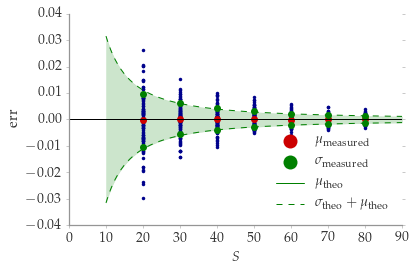

In [89]:
# Moments of distribution
mu      = 1.
sigma   = 1.
rho     = 0

# Sample errors and plot results
compare_A_corr_normal(n_samples, Ss, mu, sigma, rho)

## Positively correlated

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80


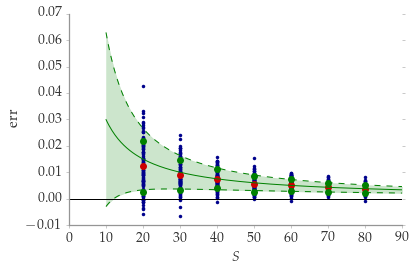

In [91]:
# Moments of distribution
mu      = 1.
sigma   = 1.
rho     = 0.3

# Sample errors and plot results
compare_A_corr_normal(n_samples, Ss, mu, sigma, rho)

## Negatively correlated

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80


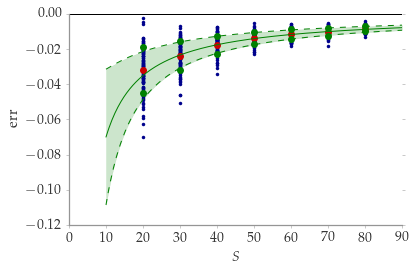

In [92]:
# Moments of distribution
mu      = 1.
sigma   = 1.
rho     = -0.7

# Sample errors and plot results
compare_A_corr_normal(n_samples, Ss, mu, sigma, rho)

# Constant diagonal

In [93]:
def compare_A_const_diag(n_samples, Ss, mu, sigma, rho, d_factor):
    # Get critical d
    def get_d_c(S, mu, sigma, rho):
        # Calculate critical d
        if mu > 0:
            d_c = (S - 1) * mu  
        else:
            d_c = np.sqrt(S * sigma**2 * (1 + rho)) - mu
        return d_c

    # Sample and calculate error
    errs = np.zeros((len(Ss), n_samples)) 
    for i, S in enumerate(Ss):
        print("Calculate error for S = %d"%S)
        for j in range(n_samples):
            # Sample A
            A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

            # Correlate off-diagonal elements
            for k in range(S):
                for l in range(k + 1, S):
                    A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

            ### Adapt diagonal
            # `Critical` value for diagonals
            d_c         = get_d_c(S, mu, sigma, rho) 
            d           = d_c * d_factor
            np.fill_diagonal(A, -d)
            
            # Calculate err
            num = np.einsum('ij, kl ->', A, A)
            den = S * np.einsum('ij, jk -> ', A, A)
            errs[i, j] = 1. - num / den

    # Calculate empirical means
    means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)

    # Calculate theoretical means
    m_s = mu / sigma
    mean_theo   = lambda S: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
    std_theo    = lambda S:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))
    
    
    # Plotting
    fig = plt.figure(figsize=figsize)
    ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

    for k, S in enumerate(Ss):
        ax.plot([S]*n_samples, errs[k], '.', color=colors[0])

    # Empirical means and std devs
    ax.plot(Ss, means, 'o', color=colors[1], label=mu_label)
    ax.plot(Ss, means + stds, 'o', color=colors[2], label=sigma_label)
    ax.plot(Ss, means - stds, 'o', color=colors[2])

    # Theoretical means and std devs
    S_c = np.linspace(10, max(Ss) + 10, 200)
    ax.plot(S_c, mean_theo(S_c), '-', color=colors[2], label=mu_theo_label)
    ax.plot(S_c, mean_theo(S_c) + std_theo(S_c), '--', color=colors[2], label=sigma_theo_label)
    ax.plot(S_c, mean_theo(S_c) - std_theo(S_c), '--', color=colors[2])
    ax.fill_between(S_c, mean_theo(S_c) + std_theo(S_c), mean_theo(S_c) - std_theo(S_c), color=colors[2], alpha=0.2)

    ax.axhline(0, linestyle='-', color='k')
    ax.set_xlabel(r"$S$")
    ax.set_ylabel(r"$\mathrm{err}$")
    ax.set_xlim(0, S_max + 10)
#     ax.legend(loc='best')
    style.fixticks(fig)

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80


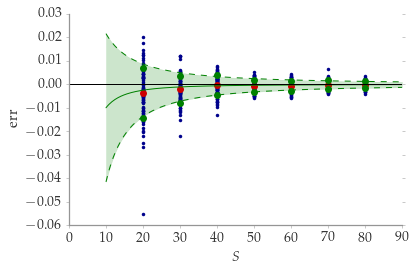

In [94]:
# Moments of distribution
mu      = 1.
sigma   = 1.
rho     = 0
d_factor    = 2

# Get and plot results
compare_A_const_diag(n_samples, Ss, mu, sigma, rho, d_factor)

### Effect of correlation, no specific diagonal

In [97]:
# Parameters for sampling
S       = 50
mu      = 1.
sigma   = 1.
d_factor = 2.
set_diagonal = False
# Choose rhos to be sampled from
rho_min = -1.
rho_max = 1
rho_step = 0.1
rhos = np.arange(rho_min, rho_max + rho_step, rho_step)

# Get critical d
def get_d_c(S, mu, sigma, rho):
    # Calculate critical d
    if mu > 0:
        d_c = (S - 1) * mu  
    else:
        d_c = np.sqrt(S * sigma**2 * (1 + rho)) - mu
    return d_c

# Sample and calculate error
errs = np.zeros((len(rhos), n_samples)) 
for i, rho in enumerate(rhos):
    print("Calculate error for d_factor = %.1f"%rho)
    for j in range(n_samples):
        # Sample A
        A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

        # Correlate off-diagonal elements
        for k in range(S):
            for l in range(k + 1, S):
                A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

        if set_diagonal:
            ### Adapt diagonal
            # `Critical` value for diagonals
            d_c         = get_d_c(S, mu, sigma, rho) 
            d           = d_c * d_factor
            np.fill_diagonal(A, -d)

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[i, j] = 1. - num / den

# Calculate empirical means
means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)



Calculate error for d_factor = -1.0
Calculate error for d_factor = -0.9
Calculate error for d_factor = -0.8
Calculate error for d_factor = -0.7
Calculate error for d_factor = -0.6
Calculate error for d_factor = -0.5
Calculate error for d_factor = -0.4
Calculate error for d_factor = -0.3
Calculate error for d_factor = -0.2
Calculate error for d_factor = -0.1
Calculate error for d_factor = -0.0
Calculate error for d_factor = 0.1
Calculate error for d_factor = 0.2
Calculate error for d_factor = 0.3
Calculate error for d_factor = 0.4
Calculate error for d_factor = 0.5
Calculate error for d_factor = 0.6
Calculate error for d_factor = 0.7
Calculate error for d_factor = 0.8
Calculate error for d_factor = 0.9
Calculate error for d_factor = 1.0


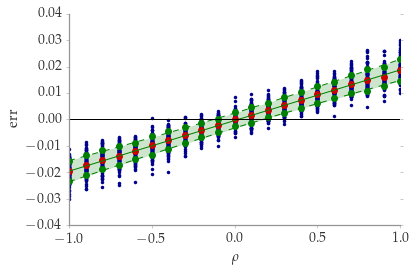

In [99]:
# Calculate theoretical means
m_s = mu / sigma
mean_theo   = lambda rho: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
std_theo    = lambda rho:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))

# Plotting
fig = plt.figure(figsize=figsize)
ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

for k, rho in enumerate(rhos):
    ax.plot([rho]*n_samples, errs[k], '.', color=colors[0])

# Empirical means and std devs
ax.plot(rhos, means, 'o', color=colors[1], label=r"$\mu_\mathrm{measured}$")
ax.plot(rhos, means + stds, 'o', color=colors[2], label=r"$\sigma_\mathrm{measured}$")
ax.plot(rhos, means - stds, 'o', color=colors[2])

# Theoretical means and std devs
rhos_c = np.linspace(max(-1, 1.2 * min(rhos)), min(1, 1.2 * max(rhos)) , 200)
ax.plot(rhos_c, mean_theo(rhos_c), '-', color=colors[2], label=r"$\mu_\mathrm{theo} = 0.$")
ax.plot(rhos_c, mean_theo(rhos_c) + std_theo(rhos_c), '--', color=colors[2], label=r"$\sigma_\mathrm{theo}$")
ax.plot(rhos_c, mean_theo(rhos_c) - std_theo(rhos_c), '--', color=colors[2])
ax.fill_between(rhos_c, mean_theo(rhos_c) + std_theo(rhos_c), mean_theo(rhos_c) - std_theo(rhos_c), color=colors[2], alpha=0.2)

ax.axhline(0, linestyle='-', color='k')
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\mathrm{err}$")
# ax.set_xlim(0, d_factor_max + 10)
# ax.set_ylim(-1, 1)
# ax.legend(loc='best')
style.fixticks(fig)

### Effect of constant diagonal

In [100]:
# Number of samples
n_samples = 500
# Parameters for sampling
S       = 50
mu      = 1.
sigma   = 1.
rho     = 0
# Choose d_factors to be sampled from
d_factor_min = 0.6
d_factor_max = 1.4
d_factor_step = 0.1
d_factors = np.arange(d_factor_min, d_factor_max + d_factor_step, d_factor_step)

# Get critical d
def get_d_c(S, mu, sigma, rho):
    # Calculate critical d
    if mu > 0:
        d_c = (S - 1) * mu  
    else:
        d_c = np.sqrt(S * sigma**2 * (1 + rho)) - mu
    return d_c

# Sample and calculate error
errs = np.zeros((len(d_factors), n_samples)) 
for i, d_factor in enumerate(d_factors):
    print("Calculate error for d_factor = %.1f"%d_factor)
    for j in range(n_samples):
        # Sample A
        A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

        # Correlate off-diagonal elements
        for k in range(S):
            for l in range(k + 1, S):
                A[l, k] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[k, l] + np.sqrt(1 - rho**2) * A[l, k]

        ### Adapt diagonal
        # `Critical` value for diagonals
        d_c         = get_d_c(S, mu, sigma, rho) 
        d           = d_c * d_factor
        np.fill_diagonal(A, -d)

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[i, j] = 1. - num / den

# Calculate empirical means
means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)

# Calculate theoretical means
m_s = mu / sigma
mean_theo   = lambda d_factor: ((S - 2) * rho - 1) / (S**2 * m_s**2 * (d_factor - 1)**2)
std_theo    = lambda d_factor:  np.sqrt((2 * m_s**2 * rho + (rho - 1)**2) / (S**3 * m_s**4 * (d_factor - 1)**4))



Calculate error for d_factor = 0.6
Calculate error for d_factor = 0.7
Calculate error for d_factor = 0.8
Calculate error for d_factor = 0.9
Calculate error for d_factor = 1.0
Calculate error for d_factor = 1.1
Calculate error for d_factor = 1.2
Calculate error for d_factor = 1.3
Calculate error for d_factor = 1.4


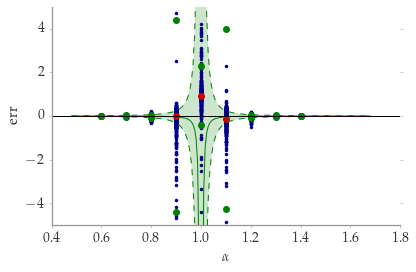

In [105]:
# Plotting
fig = plt.figure(figsize=figsize)
ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

for k, d_factor in enumerate(d_factors):
    ax.plot([d_factor]*n_samples, errs[k], '.', color=colors[0])

# Empirical means and std devs
ax.plot(d_factors, means, 'o', color=colors[1], label=mu_label)
ax.plot(d_factors, means + stds, 'o', color=colors[2], label=sigma_label)
ax.plot(d_factors, means - stds, 'o', color=colors[2])

# Theoretical means and std devs
d_factors_c = np.linspace(0.8 * min(d_factors), 1.2 * max(d_factors) , 200)
ax.plot(d_factors_c, mean_theo(d_factors_c), '-', color=colors[2], label=mu_theo_label)
ax.plot(d_factors_c, mean_theo(d_factors_c) + std_theo(d_factors_c), '--', color=colors[2], label=sigma_theo_label)
ax.plot(d_factors_c, mean_theo(d_factors_c) - std_theo(d_factors_c), '--', color=colors[2])
ax.fill_between(d_factors_c, mean_theo(d_factors_c) + std_theo(d_factors_c), mean_theo(d_factors_c) - std_theo(d_factors_c), color=colors[2], alpha=0.2)

ax.axhline(0, linestyle='-', color='k')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\mathrm{err}$")
# ax.set_xlim(0, d_factor_max + 10)
ax.set_ylim(-5, 5)
# ax.legend(loc='best')
style.fixticks(fig)

## $A_{ij} > 0 \sim$ log-normal, iid, uncorrelated

The log-normal distribution has the following moments:

> $ \mu_l      = e^{\mu +\sigma ^{2}/2} $ 
 
> $ \sigma_l^2 = (e^{\sigma ^{2}}\!\!-1)e^{2\mu +\sigma ^{2}} $

> $ \mu_{l, 3} = (e^{\sigma ^{2}}\!\!+2){\sqrt {e^{\sigma ^{2}}\!\!-1}} \cdot \sigma_l^3 $

> $ \mu_{l, 4} = (e^{4\sigma ^{2}}\!\!+2e^{3\sigma ^{2}}\!\!+3e^{2\sigma ^{2}}\!\!-3) \cdot \sigma_l^4 $

where $\mu$ and $\sigma$ are the mean and variance of the underlying normal distribution.


Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80
Calculate error for S = 90
Calculate error for S = 100
Calculate error for S = 110
Calculate error for S = 120
mean(err)_measured   std(err)_theo  std(err)_measured
-0.000765            0.019211       0.018378
-0.000407            0.010457       0.009712
-0.000045            0.006792       0.007001
-0.000335            0.004860       0.004961
 0.000213            0.003697       0.003720
 0.000113            0.002934       0.002974
 0.000011            0.002401       0.002351
-0.000083            0.002012       0.002031
-0.000140            0.001718       0.001689
-0.000009            0.001489       0.001460
 0.000022            0.001307       0.001339


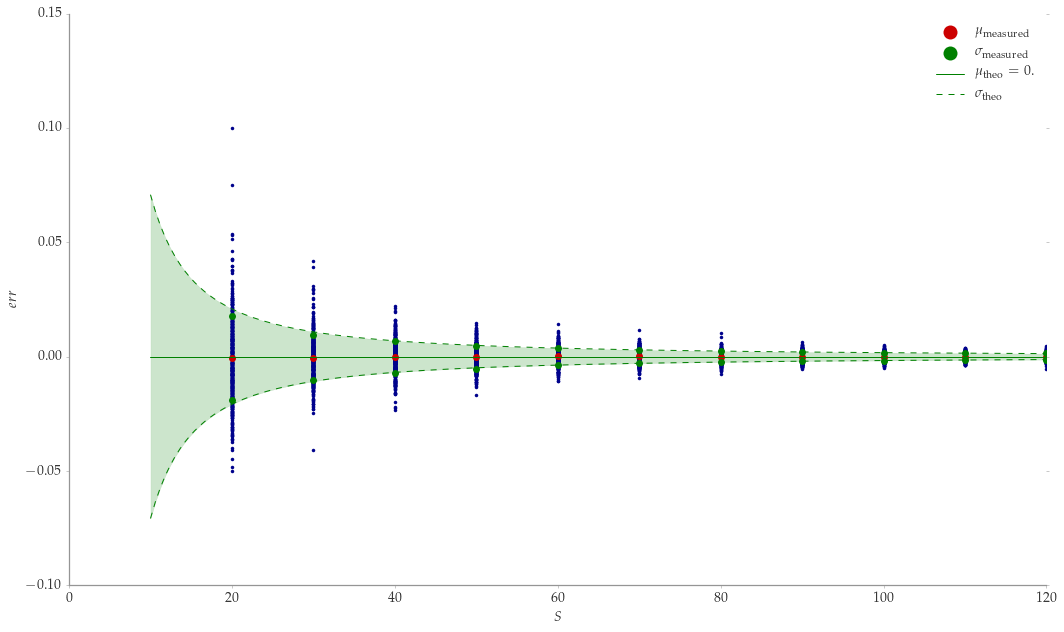

In [5]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Mean and variance of underlying gaussian
mu_normal       = 0.
sigma_normal    = 1.

# Moments of actual distribution
mu      = np.exp(mu_normal + sigma_normal**2 / 2.)
sigma   = np.sqrt((np.exp(sigma_normal**2) - 1.) * np.exp(2 * mu_normal + sigma_normal**2))
mu_3    = (np.exp(sigma_normal**2) + 2) * np.sqrt(np.exp(sigma_normal**2) - 1.) * sigma**3
mu_4    = (np.exp(4 * sigma_normal**2) + 2 * np.exp(3 * sigma_normal**2) + 3 * np.exp(2 * sigma_normal**2) - 3) * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.lognormal(mean=mu_normal, sigma=sigma_normal, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)

## Worst case scenario: zero mean 

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80
Calculate error for S = 90
Calculate error for S = 100
Calculate error for S = 110
Calculate error for S = 120
mean(err)_measured   std(err)_theo  std(err)_measured
 2.065229            0.929320       23.242222
 0.577690            0.951972       4.444385
 0.953040            0.963624       2.181712
 0.851533            0.970725       3.579824
 0.958234            0.975506       0.974556
 1.230069            0.978945       3.602771
-1.687720            0.981537       61.330880
-0.970840            0.983561       40.820046
 0.085130            0.985184       32.982200
 0.874142            0.986516       1.554254
 0.948826            0.987628       1.726430


/home/fs/Code/env2_7/local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


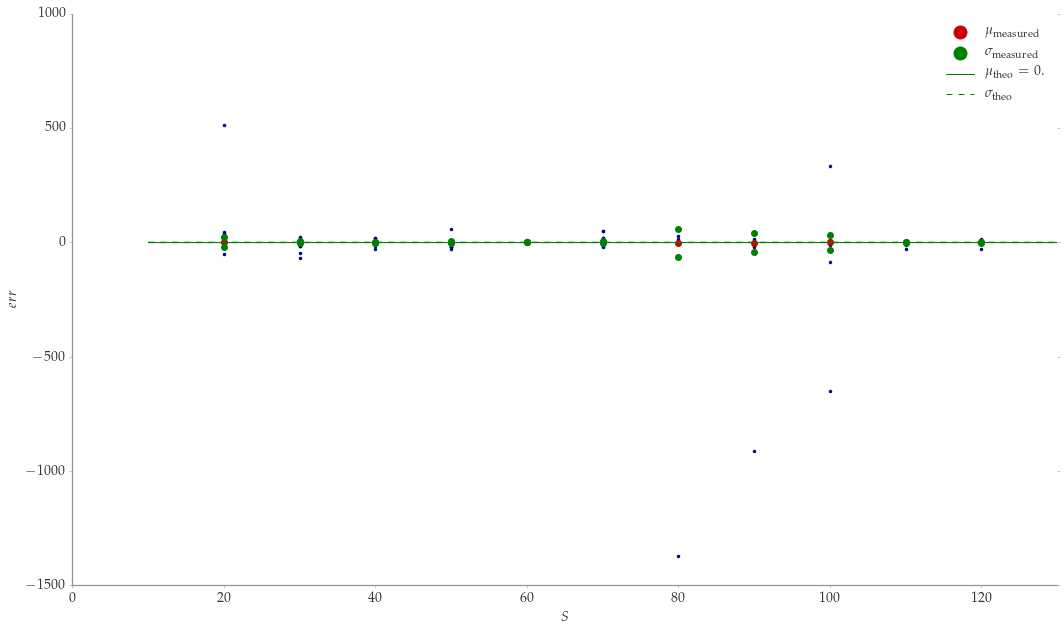

In [2]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Moments of distribution
mu      = 0.
sigma   = 1.
mu_3    = 0. * sigma**3
mu_4    = 3. * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)

# Correlated opposites

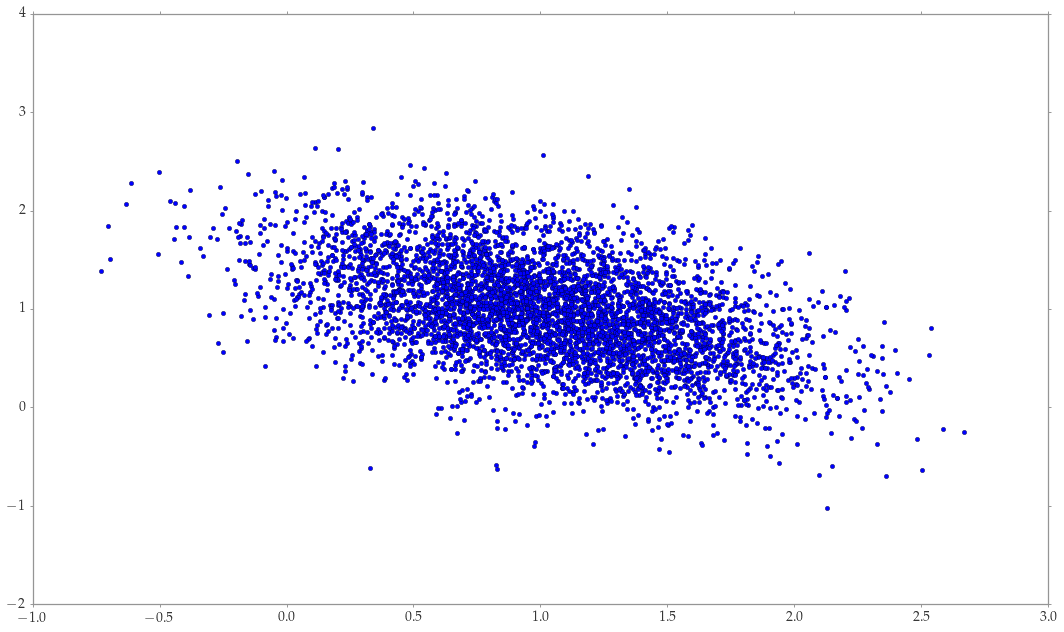

In [73]:


def get_corr_normal_A(mu, sigma, S, rho):
    # Sample A
    A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

    # Correlate off-diagonal elements
    for i in range(S):
        for j in range(i + 1, S):
            A[j, i] = mu * (1. - rho - np.sqrt(1 - rho**2)) + rho * A[i, j] + np.sqrt(1 - rho**2) * A[j, i]
            
    return A

# Test: Plot correlate elements
mu = 1.
sigma = 0.5
S = 100
rho = -0.5

A = get_corr_normal_A(mu, sigma, S, rho)
xs = []
for i in range(S):
    for j in range(i + 1, S):
        xs.append([A[i, j], A[j, i]])
xs= np.asarray(xs)        

# Plotting
fig = plt.figure(figsize=figsize)
ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

ax.scatter(xs[:, 0], xs[:, 1])


In [ ]:

#     # Printing results
#     print("size S        mean(err)_measured   std(err)_theo  std(err)_measured")
#     for mean, S , std in zip(means, Ss, stds):
#         if mean < 0:
#             print("%6d        %.6f            %.6f       %.6f"%(S, mean, std_theo(S), std))
#         else:
#             print("%6d        %.6f            %.6f       %.6f"%(S, mean, std_theo(S), std))



In [ ]:

#     mu_3    = 0. * sigma**3
#     mu_4    = 3. * sigma**4
#     std_theo_full = lambda S:  np.sqrt((
#             (S**3 - S**2 - 3*S + 3) * sigma**4 + (S - 1) * mu_4) / (
#             S**6 * mu**4 + 6 * S**4 * sigma**2 * mu**2 + (S**3 + 2 * S**2 - 3 * S) * sigma**4 + 4 * S**2 * mu_3 * mu + S * mu_4))